# Exploratory Data Analysis

We have a total of 429.303 labeled samples with 6 emotions: ['sadness' 'joy' 'love' 'anger' 'fear' 'surprise']

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset
dataset_path = "../data/datasets/process/merged_emotions.parquet"

df = pd.read_parquet(dataset_path)
df.describe()

,label
count,429303.000000
mean,1.571920
std,1.489481
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [17]:
# Custom colors for emotions
custom_palette = {
    'anger': '#FF4B4B',    # Red
    'joy': '#228B22',       # Forest Green
    'sadness': '#1E90FF',  # Blue
    'fear': '#800080',     # Purple
    'love': '#FF69B4',     # Pink
    'surprise': '#FFA500'  # Orange
}

## Data Distribution

emotions
joy         0.338463
sadness     0.285302
anger       0.145364
fear        0.115052
love        0.080647
surprise    0.035173
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Distribution of Emotions')

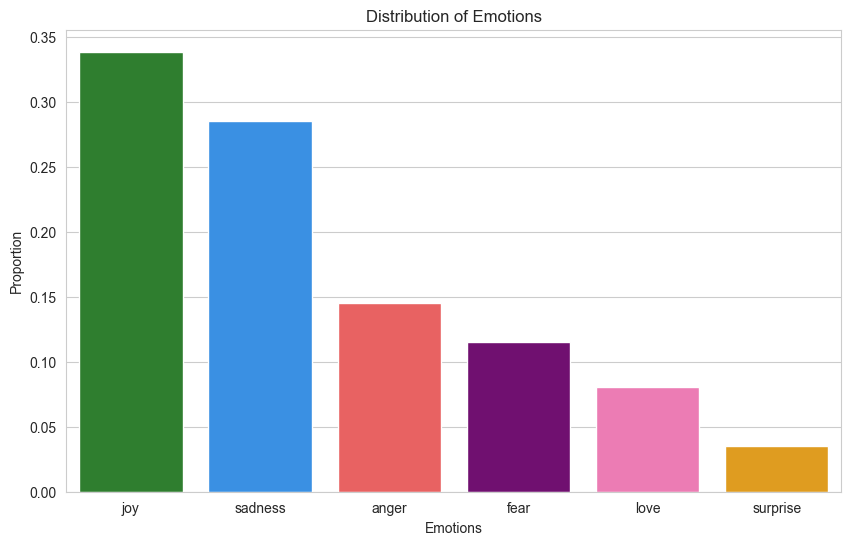

In [18]:
# Compute distribution
distributions=df['emotions'].value_counts(normalize=True)
print(distributions)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.countplot(data=df, x='emotions', order = distributions.index, palette=custom_palette, hue='emotions', legend=False,stat='proportion')
plt.xlabel('Emotions')
plt.ylabel('Proportion')
plt.title('Distribution of Emotions')

Data is unbalanced
- "joy" and "sadness" class are the most popular ones
- "surprise" is the class with the lowest samples

A classifier is expect to perform worst on "surprise" tweets and best on "joy" and "sadness" tweets

## Text Analysis
Since dataset is composed of textual data, it is insightful to make some analysis.

First i apply the Preprocessing Pipeline previously defined to extract tokens.
Then i compute some common statistics for **tweet length** (num of tokens in a preprocessed tweet):
- mean
- standard deviation
- median
- longest and shortest tweets

In [34]:
# Extract all words
def compute_stats(target_df):

  # Extract words and words frequency
  all_words = []
  all_tweets_length = []
  for tweet in target_df['text']:
    all_words.extend(tweet)
    all_tweets_length.append(len(tweet))

  stats = {}

  stats["Mean"] = np.mean(all_tweets_length)
  stats["Median"] = np.median(all_tweets_length)
  stats["Max"] = np.max(all_tweets_length)
  stats["Min"] = np.min(all_tweets_length)
  stats["Standard Deviation"] = np.std(all_tweets_length)
  return stats, all_tweets_length


stats,all_tweets_length = compute_stats(df)


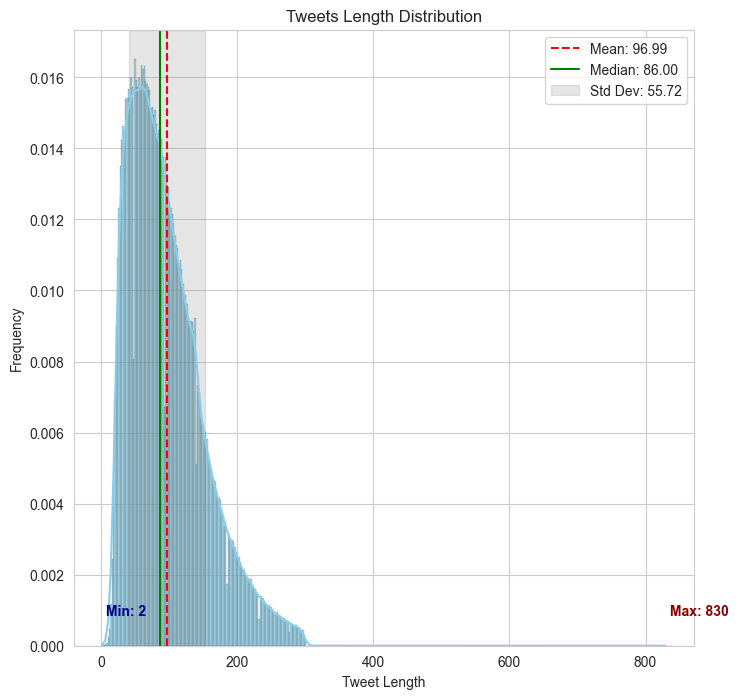

In [35]:
# Plot line graph with Tweet Lenght on the X and Frequency on the Y
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")
sns.histplot(all_tweets_length, kde=True, color='skyblue', edgecolor='black', alpha=0.7, stat='proportion')
plt.axvline(stats["Mean"], color='red', linestyle='--', label=f'Mean: {stats["Mean"]:.2f}')
plt.axvline(stats["Median"], color='green', linestyle='-', label=f'Median: {stats["Median"]:.2f}')
plt.axvspan(stats["Mean"] - stats["Standard Deviation"], stats["Mean"] + stats["Standard Deviation"],
            color='grey', alpha=0.2, label=f'Std Dev: {stats["Standard Deviation"]:.2f}')
plt.text(stats["Max"], plt.ylim()[1]*0.05, f' Max: {stats["Max"]}', color='darkred', fontweight='bold')
plt.text(stats["Min"], plt.ylim()[1]*0.05, f' Min: {stats["Min"]}', color='darkblue', fontweight='bold')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Tweets Length Distribution')
plt.legend()

The mean tweet is 19.21 tokens long. The median is at the left of the mean, making the distribution right skeewed because most users write short tweets.

**Padding**: for this task i'm gonna use a tokenizer, choosing a max_len too high is inconvenient if most of the data falls between 0 and 75.

**Outliers**: the distribution has a long tail, but the tweets with >70 lengths have a low frequency, hence may be potential outliers.

Next i'm gonna plot the boxplot of the data.
A box plot shows the distribution of quantitative data in a way that facilitates comparisons between classes (in this case, emotion)

Text(0.5, 1.0, 'Boxplot of Tweet Length by Emotion')

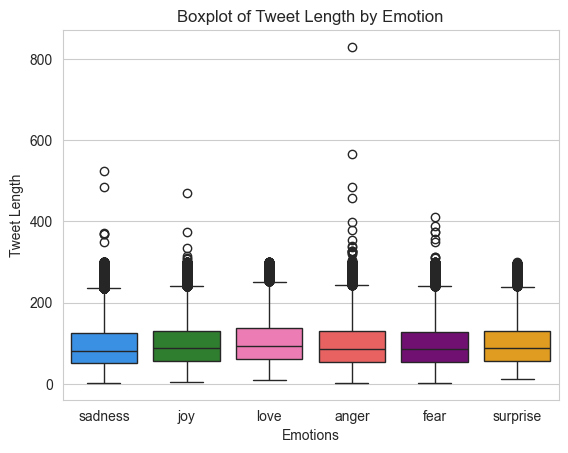

In [36]:
sns.boxplot(x="emotions",
            y=all_tweets_length,
            data=df,
            palette=custom_palette,
            hue='emotions')
plt.xlabel('Emotions')
plt.ylabel('Tweet Length')
plt.title('Boxplot of Tweet Length by Emotion')

There is no substantial differences for tweet length across different emotions.

## N-Gram Analysis
In this section i'll compute most frequent unigram (words)

In [46]:
from collections import Counter
import nltk 
nltk.download('punkt_tab')
from nltk import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) # I remove stop words

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tech\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tech\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
# Find most frequent unigrams
all_unigrams = [
    word for text in df['text']
    for word in nltk.word_tokenize(str(text).lower())
    if word.isalnum() and word not in stop_words
]

# Count the most common words
counts = Counter(all_unigrams).most_common(10)
words, freq = zip(*counts)

Text(0, 0.5, '')

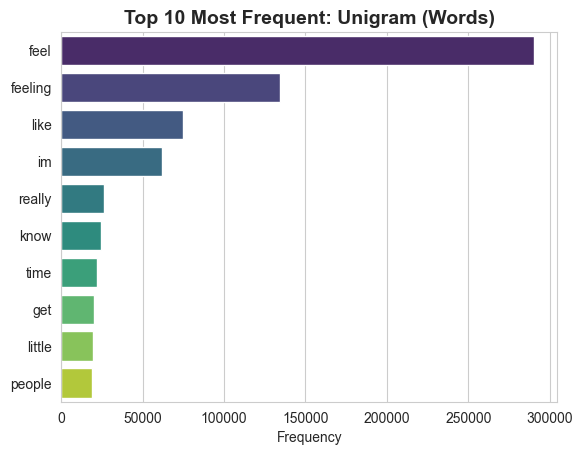

In [48]:
# Plot most frequent unigrams
sns.set_style("whitegrid")

ax = sns.barplot(
    x=list(freq),
    y=list(words),
    hue=list(words),
    palette='viridis',
    legend=False
)


plt.title(f'Top 10 Most Frequent: Unigram (Words)', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('')


"feel" and "feeling" are two words that are very frequent in the text. This **probably reflects how data was collected**, by selecting tweets that contains words like "feel" and "feeling".

In this way it's easy to collect tweets that may contains information like "i feel devastated" or "i feel angry" and associated "angry" and "sad" to emotional states.

## Most frequent Bi-grams and Trigrams

In [49]:
# Find bigrams
all_bigrams = []

for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 2:
        all_bigrams.extend(list(ngrams(filtered_tokens, 2)))


counts_bi = Counter(all_bigrams).most_common(10)
words_bi = [' '.join(w) for w, f in counts_bi]
freq_bi = [f for w, f in counts_bi]

# Find trigrams
all_trigrams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    all_trigrams.extend(list(ngrams(tokens, 3)))

counts_tri = Counter(all_trigrams).most_common(10)
words_tri = [' '.join(w) for w, f in counts_tri]
freq_tri = [f for w, f in counts_tri]

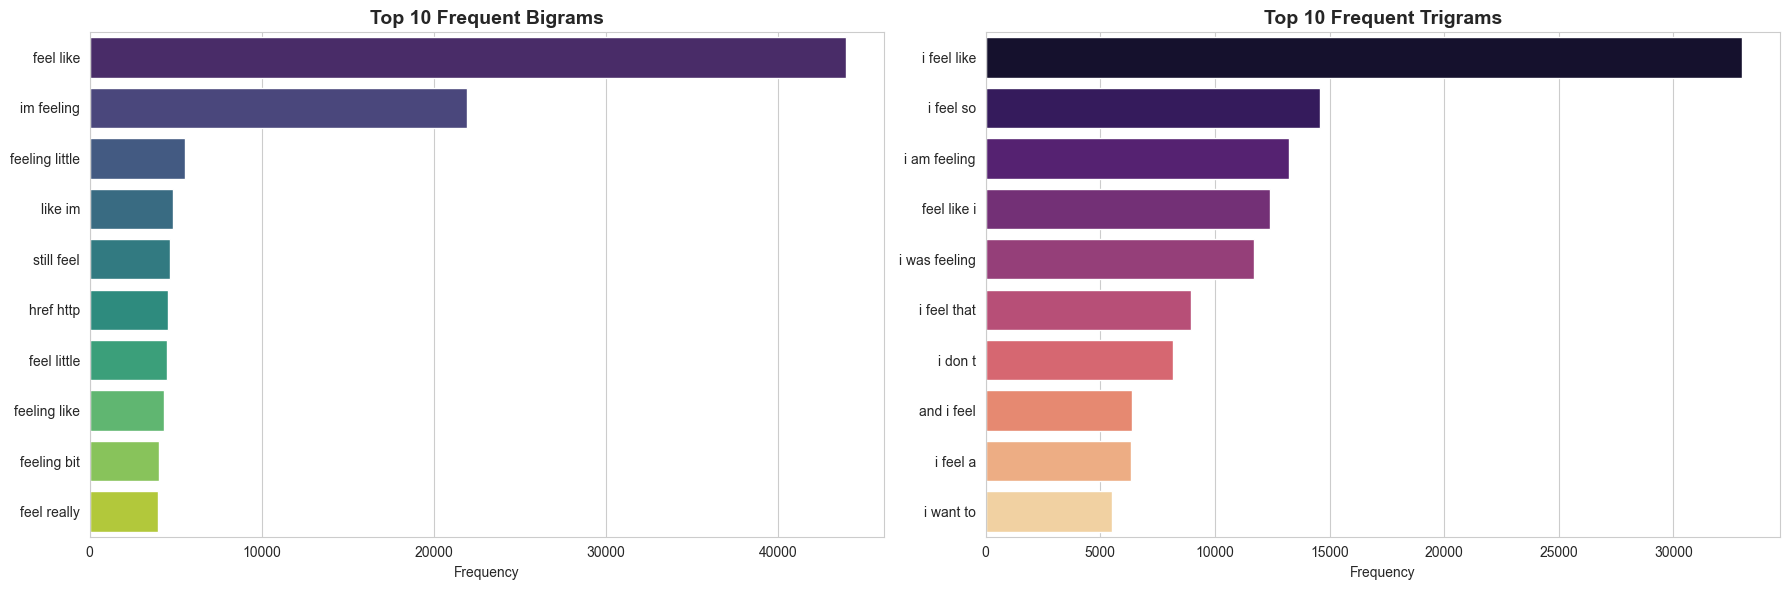

In [50]:
# Plot most frequent bigram and trigram

# Create a figure with 1 row and 2 columns, wide enough for text
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# --- Left Plot: Bigrams ---
sns.barplot(
    x=freq_bi,
    y=words_bi,
    hue=words_bi,
    palette='viridis',
    legend=False,
    ax=axes[0]  # This places it in the first (left) slot
)
axes[0].set_title('Top 10 Frequent Bigrams', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')

# --- Right Plot: Trigrams ---
sns.barplot(
    x=freq_tri,
    y=words_tri,
    hue=words_tri,
    palette='magma', # Used a different palette to visually distinguish
    legend=False,
    ax=axes[1]  # This places it in the second (right) slot
)
axes[1].set_title('Top 10 Frequent Trigrams', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency')

# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.show()

## Most frequent 4- and 5- Grams

In [51]:
# Find 4-Grams
all_4grams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 4:
        all_4grams.extend(list(ngrams(filtered_tokens, 4)))

counts_four = Counter(all_4grams).most_common(10)
words_four = [' '.join(w) for w, f in counts_four]
freq_four = [f for w, f in counts_four]


# Find 5-Grams
all_5grams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 5:
        all_5grams.extend(list(ngrams(filtered_tokens, 5)))

counts_five = Counter(all_5grams).most_common(10)
words_five = [' '.join(w) for w, f in counts_five]
freq_five = [f for w, f in counts_five]

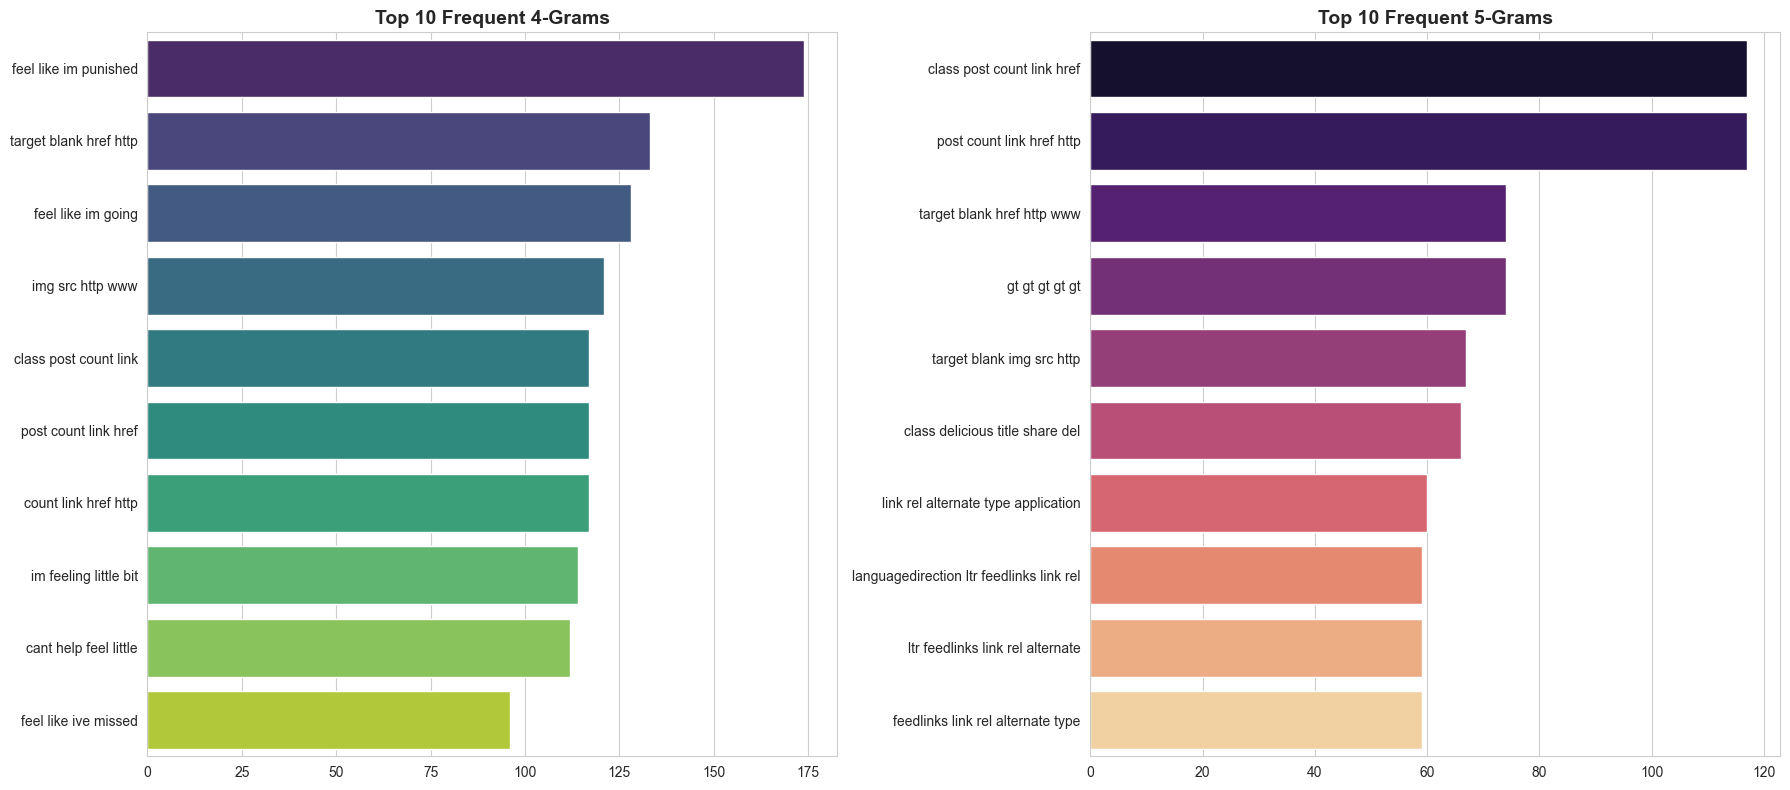

In [52]:
# Plot 4- and 5-Grams

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# Left Plot: 4-Grams
sns.barplot(x=freq_four, y=words_four, hue=words_four, palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('Top 10 Frequent 4-Grams', fontsize=14, fontweight='bold')

# Right Plot: 5-Grams
sns.barplot(x=freq_five, y=words_five, hue=words_five, palette='magma', legend=False, ax=axes[1])
axes[1].set_title('Top 10 Frequent 5-Grams', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Top 10 most frequent 5 and 4-grams were useful to find some noise in the data.

## N-Gram comparison between classes
As before, stop words are deleted

In [53]:
# Compute subsets
df_sadness = df[df['emotions'] == 'sadness']
df_joy = df[df['emotions'] == 'joy']
df_love = df[df['emotions'] == 'love']
df_anger = df[df['emotions'] == 'anger']
df_fear = df[df['emotions'] == 'fear']
df_surprise = df[df['emotions'] == 'surprise']

In [54]:
def get_filtered_ngrams(dataframe, n, top_n=10):
    all_grams = []
    # Use the same stop words we defined earlier
    stop_words = set(nltk.corpus.stopwords.words('english'))

    banned = {}

    for text in dataframe['text']:
        # 1. Tokenize the CURRENT row
        tokens = nltk.TweetTokenizer().tokenize(str(text).lower())

        # 2. Filter words
        filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words and t not in banned]

        # 3. Only create ngrams if we have enough tokens
        if len(filtered_tokens) >= n:
            raw_grams = list(ngrams(filtered_tokens, n))

            all_grams.extend(raw_grams)

    counts = Counter(all_grams).most_common(top_n)

    # If the list is empty, handle it gracefully
    if not counts:
        return [], []

    words = [' '.join(w) for w, f in counts]
    freq = [f for w, f in counts]
    return words, freq

Find most frequent 2- and 3-Grams for each emotion

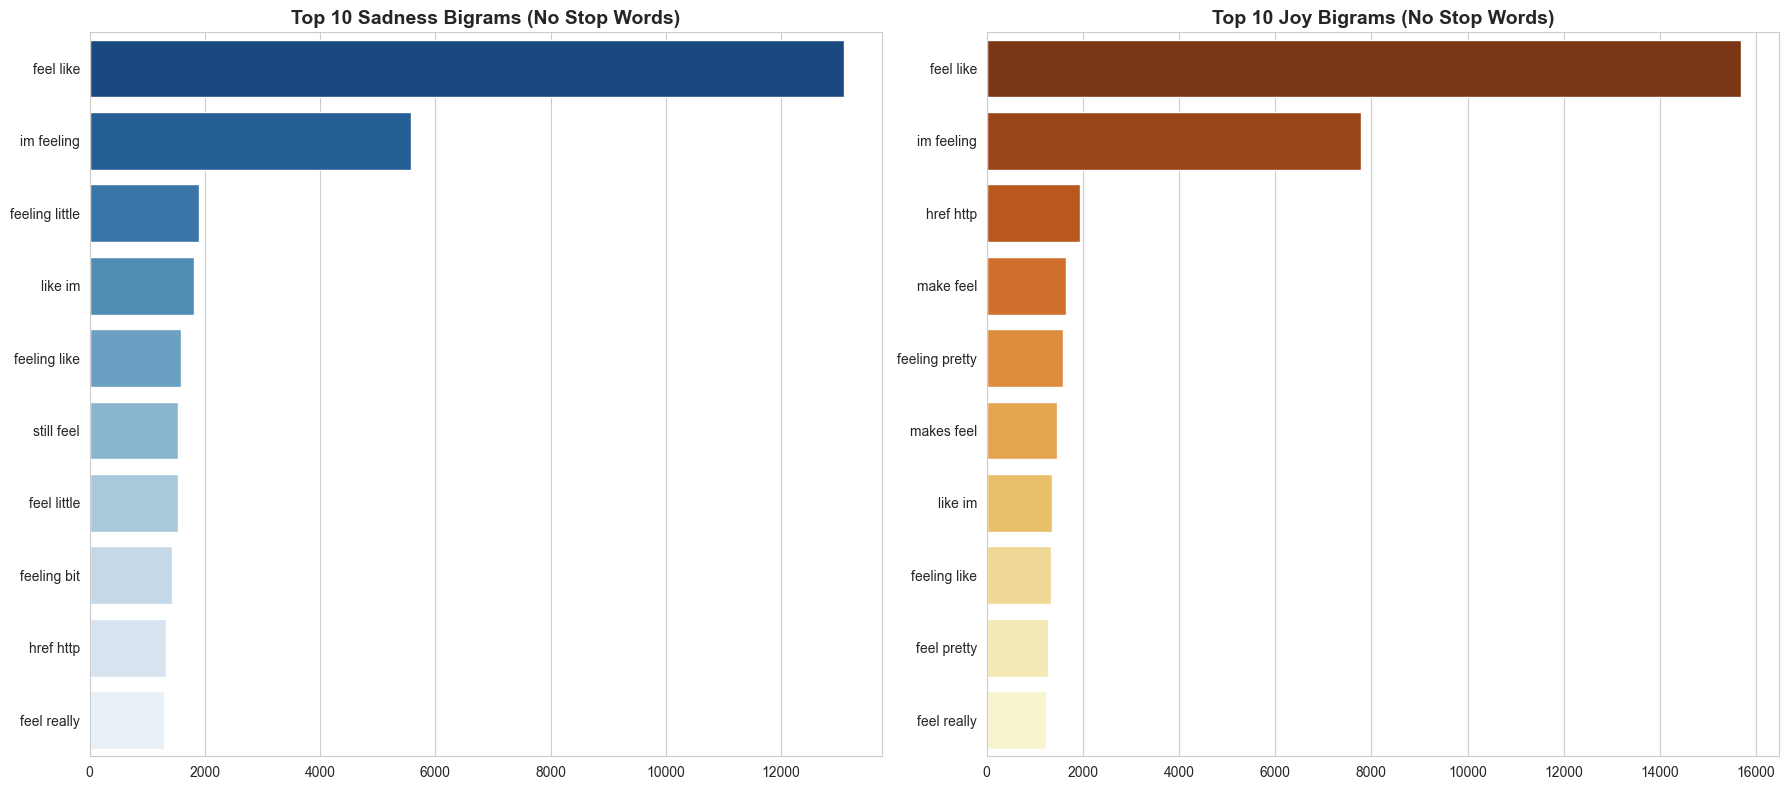

In [55]:
# Sadness and Joy
words_bi_sad, freq_bi_sad = get_filtered_ngrams(df_sadness, 2)
words_bi_joy, freq_bi_joy = get_filtered_ngrams(df_joy, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(x=freq_bi_sad, y=words_bi_sad, hue=words_bi_sad, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Sadness Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(x=freq_bi_joy, y=words_bi_joy, hue=words_bi_joy, palette='YlOrBr_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 Joy Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

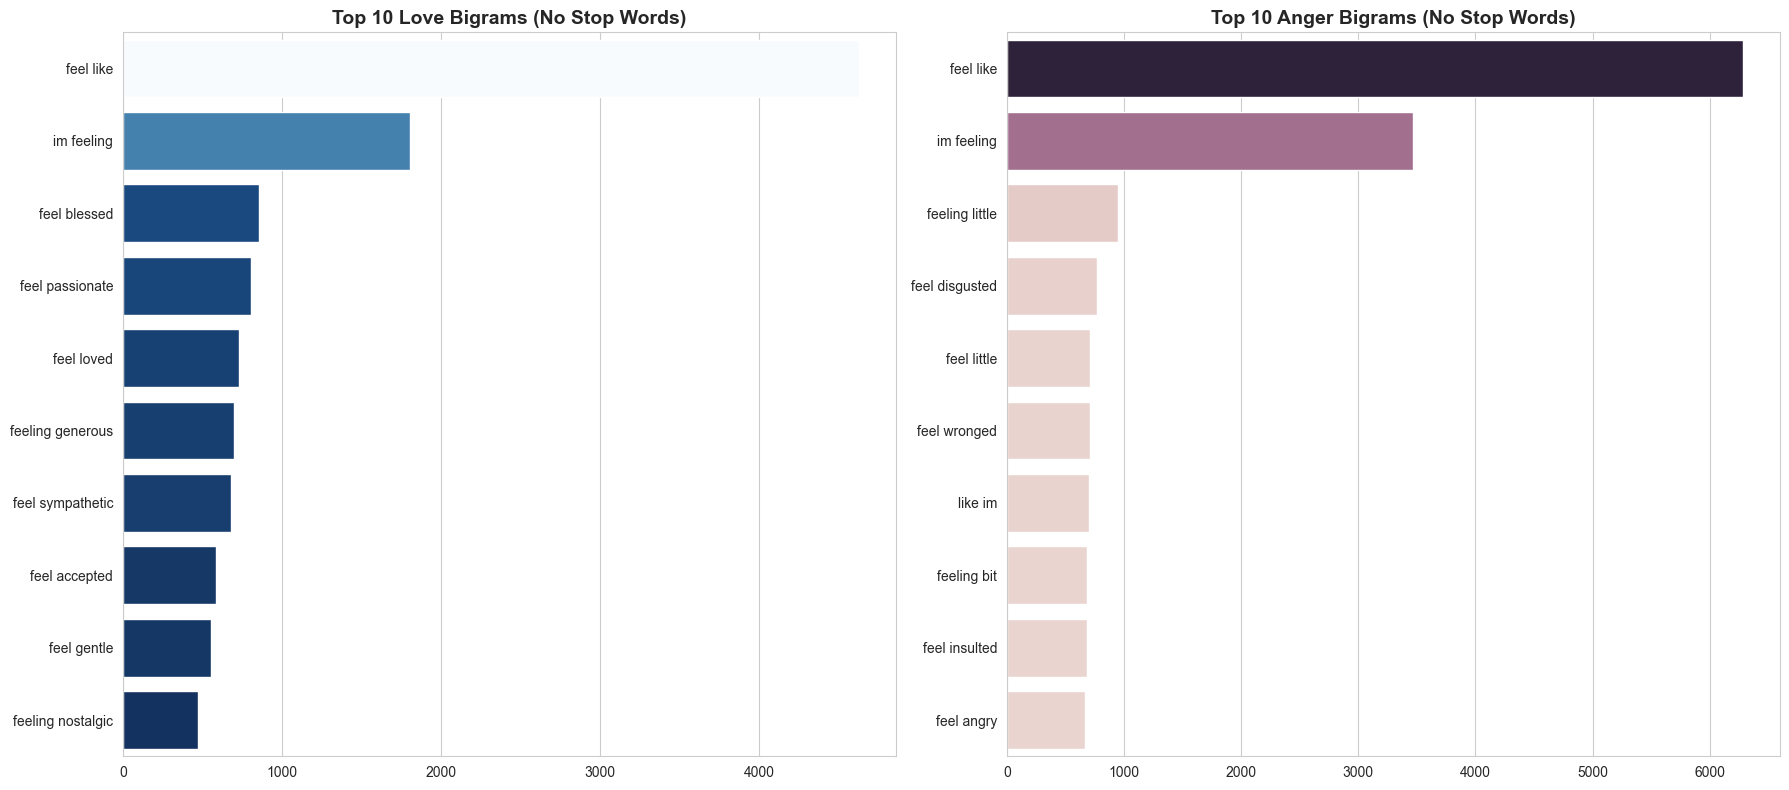

In [56]:
# Love and Anger
words_bi_love, freq_bi_love = get_filtered_ngrams(df_love, 2)
words_bi_anger, freq_bi_anger = get_filtered_ngrams(df_anger, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(y=words_bi_love, x=freq_bi_love, hue=freq_bi_love, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Love Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(y=words_bi_anger, x=freq_bi_anger, hue=freq_bi_anger, ax=axes[1], legend=False)
axes[1].set_title('Top 10 Anger Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

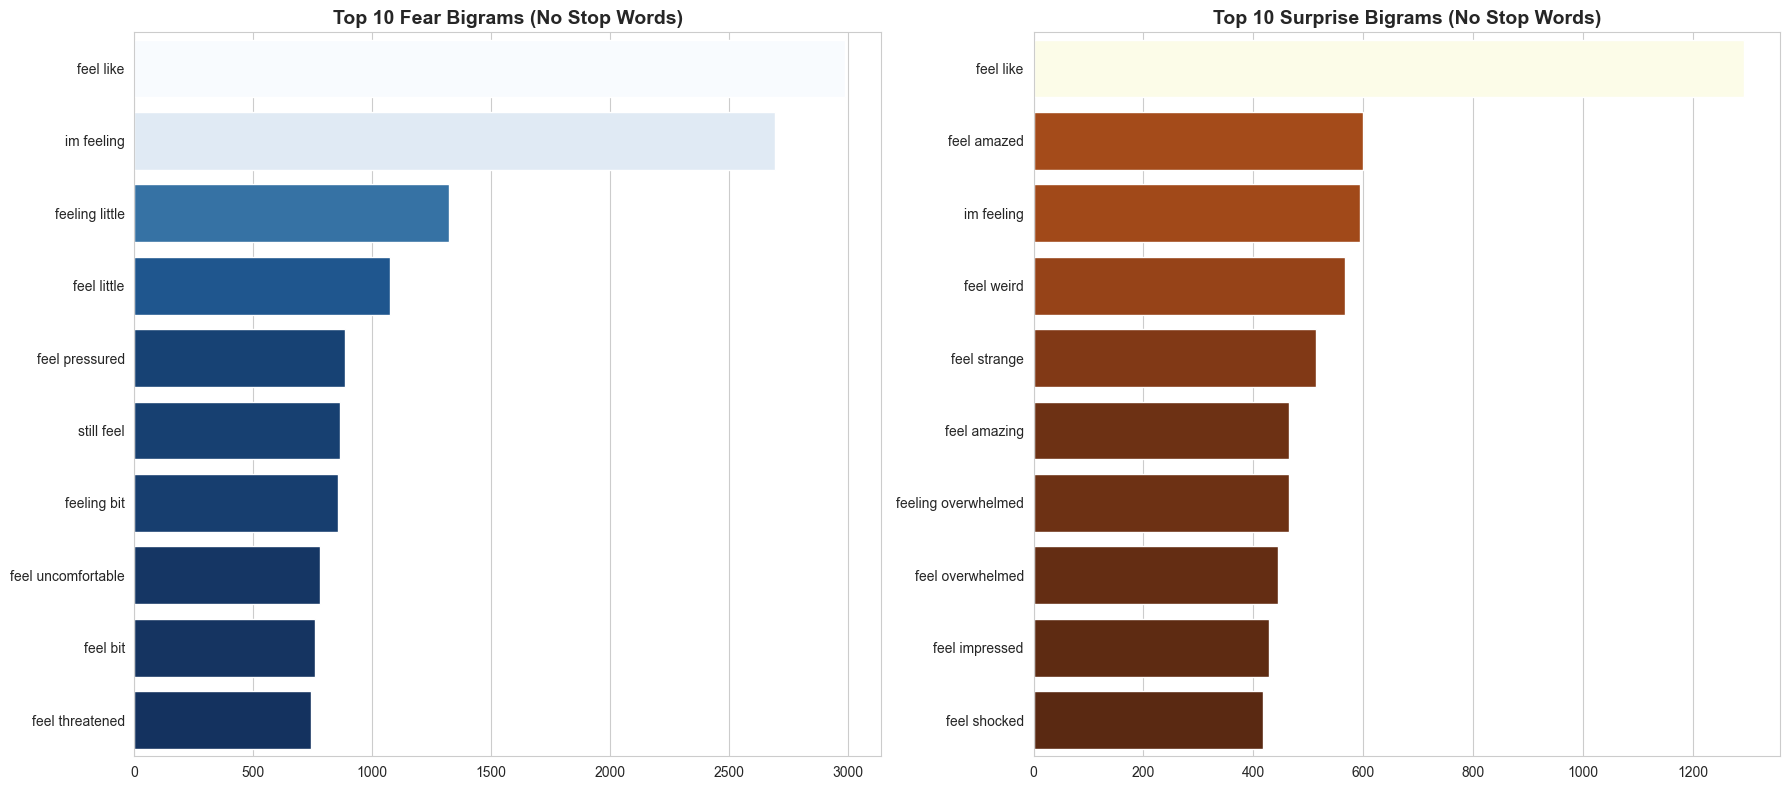

In [57]:
# Fear and Surprise
words_bi_fear, freq_bi_fear = get_filtered_ngrams(df_fear, 2)
words_bi_surprise, freq_bi_surprise = get_filtered_ngrams(df_surprise, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(y=words_bi_fear, x=freq_bi_fear, hue=freq_bi_fear, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Fear Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(y=words_bi_surprise, x=freq_bi_surprise, hue=freq_bi_surprise, palette='YlOrBr_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 Surprise Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()